# Network Colocalization Notebook

Figures generated:
- Figure 2B
- Figure 2C
- Figure 2D
- Figure 2E


### Set Up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import hypergeom
from scipy.stats import mannwhitneyu
import obonet as obo
import re
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection
from sklearn.metrics import roc_auc_score

In [2]:
cwd = os.getcwd()
datadir = os.path.join(cwd, '..')

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = os.path.join(datadir, 'Reference_Data', 'Arial.TTF')
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

In [4]:
import re
def map_trait_code(code):
    efo = next((match.group() for match in re.finditer(r'EFO_\d+', code)), None)
    if efo is not None:
        return efo
    mondo = next((match.group() for match in re.finditer(r'MONDO_\d+', code)), None)
    if mondo is not None:
        return mondo
    hp = next((match.group() for match in re.finditer(r'HP_\d+', code)), None)
    if hp is not None:
        return hp
    go = next((match.group() for match in re.finditer(r'GO_\d+', code)), None)
    if go is not None:
        return go
    oba = next((match.group() for match in re.finditer(r'OBA_\d+', code)), None)
    if oba is not None:
        return oba
    return None

In [7]:
def get_trait_pair(df, rcol='Rare Study', ccol='Common Study', efocol='EFO'):
    df['trait_pair'] = df[rcol].astype(int).astype(str) + '_' + df[efocol] +'_' +df[ccol] +'_'+ df[efocol]
    return df

## Load NetColoc Results

In [10]:
coloc_df = pd.read_csv(os.path.join(datadir, 'outputs/STable2.tsv'), sep='\t')
coloc_df = get_trait_pair(coloc_df)
df = coloc_df[coloc_df['Analysis Set']=='Initial'].copy()

In [11]:
df['StudyC']

,EFO,Trait,Common Study,Rare Study,Analysis Set,nCommon,nRare,nShared,pShared,Network,...,COLOC Score HN,COLOC P HN,COLOC -logp HN,Observed Size ST,Expected Size ST,Log2SizeOE ST,COLOC Score ST,COLOC P ST,COLOC -logp ST,trait_pair
4,EFO_0000095,chronic lymphocytic leukemia,GCST90027053,34662886,Initial,24,4,0,0.005043,PCNet2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34662886_EFO_0000095_GCST90027053_EFO_0000095
5,EFO_0000096,neoplasm of mature B-cells,GCST002643,34375979,Initial,4,8,0,0.001683,PCNet2.0,...,0.509329,1.661000e-11,10.779630,NaN,NaN,NaN,NaN,NaN,NaN,34375979_EFO_0000096_GCST002643_EFO_0000096
6,EFO_0000198,myelodysplastic syndrome,GCST009516,34375979,Initial,5,14,0,0.003679,PCNet2.0,...,0.303945,2.408000e-27,26.618344,123.0,133.584,-0.119089,0.920769,2.971000e-01,0.527097,34375979_EFO_0000198_GCST009516_EFO_0000198
7,EFO_0000217,gastritis,GCST002638,34375979,Initial,4,23,0,0.004834,PCNet2.0,...,0.759908,3.760000e-04,3.424812,144.0,169.132,-0.232081,0.851406,2.702000e-02,1.568315,34375979_EFO_0000217_GCST002638_EFO_0000217
8,EFO_0000266,aortic stenosis,GCST90276156,34375979,Initial,9,19,0,0.008966,PCNet2.0,...,1.646397,4.895000e-22,21.310247,296.0,139.678,1.083492,2.119160,2.000000e-47,46.698970,34375979_EFO_0000266_GCST90276156_EFO_0000266


In [5]:
def load_files_from_list(outdir, job_id):
    with open(os.path.join(outdir, f'{job_id}.files'), 'r') as f:
        filenames = [s.strip() for s in f.readlines()] 
    loaded_data = []
    not_found = 0
    for f in filenames:
        try:
            loaded_data.append(pd.read_csv(os.path.join(outdir, f), sep='\t', header=None))
        except:
            not_found += 1
    print(f'Files loaded {len(loaded_data)}\n', f'Files not found {not_found}')
    results = pd.concat(loaded_data)
    results.columns = ['TraitR', 'TraitC', 'Network','Transform', 'Norm', 'Mean_NPS', 
                             'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ]
    results['logp_nps'] = results.P_mean_NPS.apply(lambda x: -1 * np.log10(x+1e-250))
    results['logp_size'] = results.P_size.apply(lambda x: -1 * np.log10(x+1e-250))
    results['log2SizeOE'] = np.log2(results['Size'] / results['Null_Size'])
    return results


In [6]:
#df = pd.read_csv(os.path.join(output_dir, 'netcoloc/March_2025', 'rvc_qnetcoloc_rv_gc.txt'), sep='\t', header=None,
#                names =['TraitR', 'TraitC', 'Network','Transform', 'Norm','Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ])

df = load_files_from_list(os.path.join(output_dir, 'netcoloc', 'March_2025'), 2214576)
df['slurm_idx'] = [x for x in range(len(df))]
df['EFO'] = df.TraitR.apply(lambda x: map_trait_code(x))
df['StudyC'] = df.TraitC.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
df['StudyR'] = df.TraitR.apply(lambda x: x.split('_')[0])
df['trait_pair'] = df['TraitR'] + '_' + df['TraitC']

Files loaded 373
 Files not found 0


In [7]:
c_traitlist = pd.read_csv(os.path.join(input_dir, 'March_2025', 'common_Mar28.traitlist'), header=None)[0].values
r_traitlist = pd.read_csv(os.path.join(input_dir, 'March_2025', 'rare_Mar28.traitlist'), header=None)[0].values

In [8]:
trait_pairs = ['_'.join(x) for x in zip(r_traitlist, c_traitlist)]

In [17]:
df['q'] = fdrcorrection(df['COLOC p'].values)[1]
df['logq'] = df.q.apply(lambda z: -1 * np.log10(z + 1e-250))
df['plot_color'] = df['COLOC -logp'].apply(lambda z: min(z, 50))

In [19]:
df.columns

Index(['EFO', 'Trait', 'Common Study', 'Rare Study', 'Analysis Set', 'nCommon',
       'nRare', 'nShared', 'pShared', 'Network', 'Observed Size',
       'Expected Size', 'Log2SizeOE', 'COLOC Score', 'COLOC p', 'COLOC -logp',
       'Optimal COLOC', 'Observed Size PC22', 'Expected Size PC22',
       'Log2SizeOE PC22', 'COLOC Score PC22', 'COLOC P PC22',
       'COLOC -logp PC22', 'Observed Size HN', 'Expected Size HN',
       'Log2SizeOE HN', 'COLOC Score HN', 'COLOC P HN', 'COLOC -logp HN',
       'Observed Size ST', 'Expected Size ST', 'Log2SizeOE ST',
       'COLOC Score ST', 'COLOC P ST', 'COLOC -logp ST', 'trait_pair', 'q',
       'logq', 'plot_color'],
      dtype='object')

Load optimization results

## Figure 2B - NetColoc Spectrum

<Axes: >

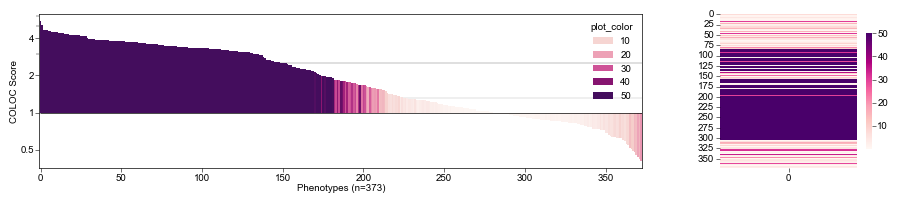

In [20]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(11, 2), gridspec_kw={'width_ratios':[7,2]})

df['plot_color'] = df.logq.apply(lambda z: min(z, 50))
sns.barplot(df.sort_values(by='Log2SizeOE', ascending=False), x='trait_pair', y='Log2SizeOE', hue='plot_color', 
            palette='RdPu', width=1, zorder=5, ax=ax1)
_ = ax1.set_xticks([])
ax1.hlines(y=[ np.log2(2.5),], xmin=-0.5, xmax=373, linestyle='-', color='black', alpha=0.6, 
           linewidth=0.3, zorder=0)
ax1.hlines(y=[ np.log2(1.3),], xmin=-0.5, xmax=373, linestyle='-', color='black', alpha=0.3, 
           linewidth=0.3, zorder=0)
ax1.hlines(y=0, xmin=-0.5, xmax=373.5, color='black', linewidth=0.5, zorder=6)
ax1.set_xlim(-0.75, 372.75)

ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
ax1.set_ylabel('COLOC Score')
ax1.set_xlabel(f'Phenotypes (n={len(df)})')
ax1.set_xticks([0, 50, 100, 150, 200, 250, 300, 350], labels = [0, 50, 100, 150, 200, 250, 300, 350])
sns.heatmap(df.plot_color.values.reshape(373, 1), cmap='RdPu', cbar_kws={'shrink':0.75})

In [21]:
print('Total sig coloc', len(df[(df.Log2SizeOE > 0) & (df.q < 0.05)]))
print('Total sig coloc %', f'{100*len(df[(df.Log2SizeOE > 0) & (df.q < 0.05)])/373:.1f}')

Total sig coloc 254
Total sig coloc % 68.1


In [22]:
print('Total strong', len(df[(df.Log2SizeOE > np.log2(2))& (df.q < 0.05)]))
print('Total strong %', 100*len(df[(df.Log2SizeOE > np.log2(2))& (df.q < 0.05)])/373)

Total strong 174
Total strong % 46.64879356568365


## Figure 2C - Categorical vs Continuous

In [34]:
info_df = pd.read_csv(os.path.join(datadir, 'outputs/STable1.tsv'), sep='\t', usecols=['Mapped EFO', 'Trait Type', 
                                                                              'Biological Domain', 'Mapped Trait']).drop_duplicates()
info_df.columns = ['TRAIT', 'EFO', 'trait_type', 'Domain']

In [35]:
type_df = df.merge(info_df.loc[:, ['EFO', 'trait_type', 'Domain']].drop_duplicates(), on='EFO', how='inner')

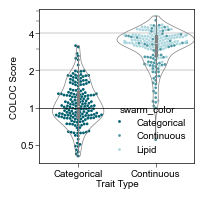

In [37]:
_ = plt.figure(figsize=(2,2))

type_df['swarm_color'] = type_df.apply(lambda x: 'Lipid' if x.Domain=='Lipid Measurement' else x.trait_type, axis=1)
sns.violinplot(type_df, x='trait_type', y='Log2SizeOE', cut=0, fill=0,color='grey', zorder=2, linewidth=0.5, width=1)
sns.swarmplot(type_df, x='trait_type', y='Log2SizeOE', hue='swarm_color', zorder=1, 
              palette=['#00606f', '#509aa5', '#ADD7DE'],  s=2)

ax1 = plt.gca()

ax1.hlines(y=[1, 2], xmin=-0.5, xmax=1.5, linestyle='-', color='grey', 
           linewidth=0.3, zorder=0)
ax1.hlines(y=0, xmin=-0.5, xmax=1.5, color='black', linewidth=0.5, zorder=6)
ax1.set_xlim(-0.5, 1.5)
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
ax1.set_xlabel('Trait Type')
_ = ax1.set_xticks([0,1], labels=['Categorical', 'Continuous'])
_ = ax1.set_ylabel('COLOC Score')

In [30]:
mannwhitneyu(type_df[type_df.trait_type=='Categorical'].Log2SizeOE.values,type_df[(type_df.trait_type=='Continuous')].Log2SizeOE.values )

MannwhitneyuResult(statistic=1173.0, pvalue=1.0565521566904869e-54)

In [38]:
print('Average COLOC, Lipid Measurement:', f'{np.mean([2*x for x in type_df[type_df.Domain=="Lipid Measurement"].Log2SizeOE.values]):.1f}')

Average COLOC, Lipid Measurement: 3.6


## Figure 2D

In [41]:
domain_map = {d:d for d in type_df.Domain.unique()}
domain_map['Pain'] = 'Other'
domain_map['Hepatic'] = 'Other'
type_df['Domain'] = type_df.Domain.map(domain_map)

In [42]:
domain_counts = pd.DataFrame({'total':type_df.groupby('Domain').EFO.count(), 
             'Colocalized': type_df[(type_df.q < 0.05) & (type_df.Log2SizeOE > 0)].groupby('Domain').EFO.count()}).fillna(0)
domain_counts['fraction'] = domain_counts.Colocalized / domain_counts.total
domain_counts.sort_values('fraction')

,total,Colocalized,fraction
Domain,,,
Infection,18,4,0.222222
Other,8,2,0.250000
Neoplasm,26,9,0.346154
Skeletal,17,6,0.352941
Dermatological,10,4,0.400000
Gastrointestinal,12,5,0.416667
Respiratory,9,4,0.444444
Muscular,9,4,0.444444
Psychiatric,8,4,0.500000


In [43]:
order = type_df.groupby('Domain').Log2SizeOE.median().sort_values().index[::-1]

In [44]:
percent_continuous = type_df.groupby('Domain').trait_type.value_counts().reset_index().pivot(index='Domain', columns='trait_type', values='count'
                                                                                            ).reset_index().fillna(0)
percent_continuous['frac'] = percent_continuous['Continuous']/(percent_continuous['Categorical']+percent_continuous['Continuous'])

Text(0, 0.5, '% Cont.')

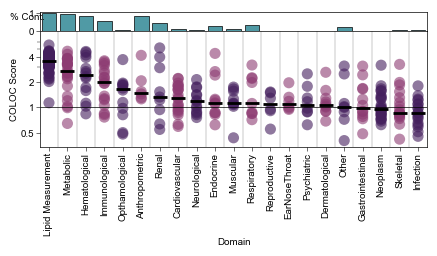

In [47]:
_, [ax2, ax1] = plt.subplots(nrows=2, ncols=1, figsize=(5, 1.75), gridspec_kw={'height_ratios':[0.5,3], 'hspace':0}, sharex=True)
sns.stripplot(type_df, x='Domain', y='Log2SizeOE', hue='Domain', jitter=0, s=8,ax=ax1,
               alpha=0.6, legend=False, palette=['#441f5d', '#8d3b72']*10+['#441f5d'], order=order, hue_order=order)
percent_contuinuous = type_df.groupby('Domain').trait_type.value_counts()
sns.barplot(percent_continuous, x='Domain', y='frac', ax=ax2, edgecolor='black', saturation=1, color='#509aa5')

# add a median bar for each value of x
sns.pointplot(type_df.groupby('Domain').Log2SizeOE.median().reset_index(), x='Domain', y='Log2SizeOE', color='black', markers='_', dodge=True, order=order, zorder=200,
              linestyle='none', markersize=10, ax=ax1)#, hue='Domain', palette=['darkblue', 'royalblue']*10+['darkblue'], hue_order=order)
ax1.tick_params(axis='x', rotation=90)
ax1.hlines(y=0, xmin=-0.5, xmax=20.5, color='black',linewidth=0.5, linestyle='-', zorder=100)
ax1.vlines(x=[i+0.5 for i in range(20)], ymin=-1.55, ymax=3, linewidth=0.3, color='grey')
ax1.set_xlim(-0.5, 20.5)
ax1.set_ylim(-1.55, 3)
ax1.set_yticks([-1, 0, 1, 2], labels=[0.5, 1, 2, 4])
_ = ax1.set_yticks(np.log2([3,5,6]), minor=True)
plt.ylabel('COLOC Score')
ax2.set_ylabel('% Cont.', rotation=0)